In [2]:
# TODO 
# data augmentation
# decide on dropout (look up chollet reference at bottom)
# learn why global average pooling is so bad?

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir('drive/My Drive/facial_features/code')

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam

from Prepare import Prepare

Using TensorFlow backend.


In [14]:
images_path = '../data/full_dataset/images_all/'
labels_path = '../data/full_dataset/landmarks_all.csv'

target_size = 80

P = Prepare(images_path, labels_path)

X, y = P.load()

X_norm = X / 255
y_norm = y / 80

X_train, X_test_, y_train, y_test_ = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

100%|██████████| 5999/5999 [00:44<00:00, 133.60it/s]


(4192, 80, 80, 3) (898, 80, 80, 3) (899, 80, 80, 3)


In [17]:
def plot_sample(X,y,axs):
    
    axs.imshow(X.reshape(target_size, target_size, 3), cmap="gray")
    axs.scatter(y[0::2], y[1::2])
#     axs.scatter(target_size/2*y[0::2]+target_size/2, target_size/2*y[1::2]+target_size/2)

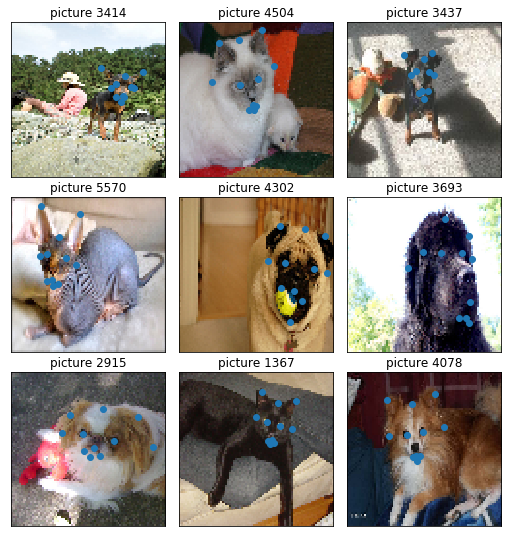

In [18]:
# plt.imshow(X[3])
# plt.scatter(y.iloc[3][0::2], y.iloc[3][1::2])

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,left=0, right=1, bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X.shape[0])
    ax = fig.add_subplot(Npicture/3, 3, count, xticks=[], yticks=[])        
    plot_sample(X[ipic], y.iloc[ipic], ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [30]:
def MyModel():
    
    model = Sequential()
    model.add(SeparableConv2D(32, 3, activation='relu', input_shape = (80, 80, 3)))
    model.add(SeparableConv2D(64, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
#     model.add(Dropout(rate=0.2))
        
    model.add(SeparableConv2D(64, 3, activation='relu'))
    model.add(SeparableConv2D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
#     model.add(Dropout(rate=0.2))    

    model.add(Flatten())
        
    model.add(Dense(64, activation='relu'))
    model.add(Dense(22))
    
    model.compile(loss="mean_squared_error", optimizer=Adam(lr=5e-5))
    
    return model
  
model = MyModel()

In [31]:
train_generator = ImageDataGenerator()
train_generator.fit(X_train)

val_generator = ImageDataGenerator()
val_generator.fit(X_val)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

hist = model.fit_generator(
                    train_generator.flow(X_train, y_train, batch_size=64), 
                    steps_per_epoch=len(X_train) / 64, 
                    epochs=50,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val)
                   )

Epoch 1/50
66/65 [==============================] - 70s 1s/step - loss: 0.0896 - val_loss: 0.1050
Epoch 2/50
66/65 [==============================] - 68s 1s/step - loss: 0.0323 - val_loss: 0.0533
Epoch 3/50
66/65 [==============================] - 70s 1s/step - loss: 0.0238 - val_loss: 0.0330
Epoch 4/50
66/65 [==============================] - 71s 1s/step - loss: 0.0189 - val_loss: 0.0210
Epoch 5/50
66/65 [==============================] - 70s 1s/step - loss: 0.0161 - val_loss: 0.0167
Epoch 6/50
66/65 [==============================] - 70s 1s/step - loss: 0.0144 - val_loss: 0.0160
Epoch 7/50
66/65 [==============================] - 70s 1s/step - loss: 0.0133 - val_loss: 0.0146
Epoch 8/50
66/65 [==============================] - 72s 1s/step - loss: 0.0127 - val_loss: 0.0146
Epoch 9/50
66/65 [==============================] - 69s 1s/step - loss: 0.0123 - val_loss: 0.0142
Epoch 10/50
66/65 [==============================] - 69s 1s/step - loss: 0.0119 - val_loss: 0.0139
Epoch 11/50
66/65 [

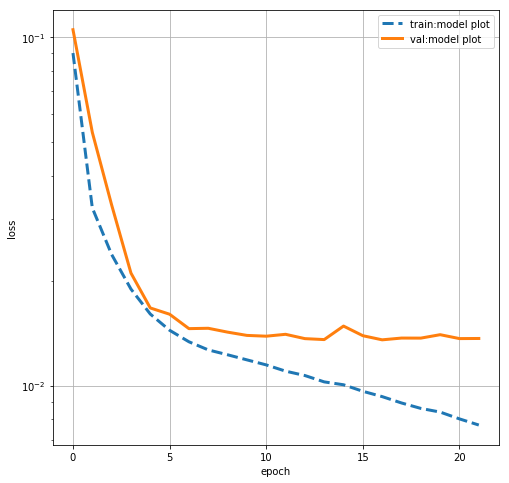

In [32]:
 def plot_loss(hist, name, plt, RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss)) * target_size/2 
        val_loss = np.sqrt(np.array(val_loss)) * target_size/2 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plt.figure(figsize=(8,8))
plot_loss(hist, "model plot", plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [33]:
model.load_weights('../models/my_model.h5')

In [34]:
def save_model(model, name):
    json_string = model.to_json()
    open("../models/"+name+'_architecture.json', 'w').write(json_string)
    model.save_weights("../models/"+name+'_weights.h5')
    model.save("../models/"+name+'_weights_and_all.h5')

def load_model(name):
    model = model_from_json(open("../models/"+name+'_architecture.json').read())
    model.load_weights("../models/"+name + '_weights.h5')
    model.compile(loss="mean_squared_error", optimizer=Adam())
    return model

In [35]:
model = load_model("my_model")
save_model(model, "my_model")

In [36]:
model.evaluate(X_test, y_test)

899/899 [==============================] - 5s 5ms/step


1449.2316477672675

In [37]:
y_pred = model.predict(X_test)

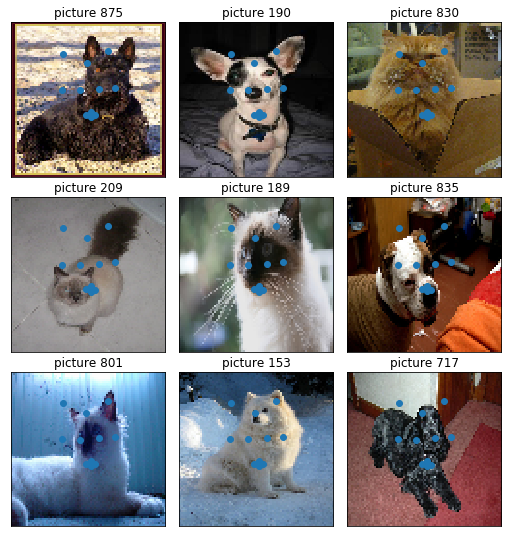

In [38]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic], y_pred[ipic], ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [ ]:
# Depthwise seqarable convolutions
######################################################################
# from keras.models import Sequential, Model
# from keras import layers

# height = 64
# width = 64
# channels = 3
# num_classes = 10

# model = Sequential()
# model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.MaxPooling2D(2))

# model.add(layers.SeparableConv2D(64, 3, activation='relu'))
# model.add(layers.SeparableConv2D(128, 3, activation='relu'))
# model.add(layers.GlobalAveragePooling2D())

# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(num_classes, activation='softmax'))

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Weight/L2 regularisation 
######################################################################
# from keras import regularizers

# model = models.Sequential()
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# Callbacks like early stopping and learning rate scheduling
######################################################################

# Tensorboard
######################################################################

# Pretrained Xception weights
######################################################################

# No dropout on conv layers but big fully connected layers at end with dropout
######################################################################